In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

import random

from IPython.display import clear_output
import torch.optim as optim

1024 2d images in train, 256 in validation

## Data preparation

In [ ]:
indexes = list(range(1024))
random.shuffle(indexes)

In [ ]:
start_end_array = [[41, 41+256], [78, 78+256], [84, 84+256], [161, 161+256], [0, 0+256]]
#images selected through napari with high-quality semi-automatic segmentation

In [ ]:
def create_mask(upper_layer, second_layer):
    mask = np.zeros((256, 512, 512), dtype=int)
    for x in range(512):
        for y in range(512):
            z1 = upper_layer[x, y]
            z2 = second_layer[x, y]
            mask[int(z1):int(z2), y, x] = 1
    return mask

In [ ]:
def from_levels_to_masks(levels):
    masks = np.zeros((5, 256, 512, 512), dtype=int)
    zero_level = np.zeros((512, 512))
    last_level = np.ones((512, 512)) * 255
    masks[0] = create_mask(zero_level, levels[0])
    masks[1] = create_mask(levels[0], levels[1])
    masks[2] = create_mask(levels[1], levels[2])
    masks[3] = create_mask(levels[2], levels[3])
    masks[4] = create_mask(levels[3], last_level)
    return masks

In [ ]:
def cutted_array(data, masks, start, end):
    return data[:, :, start:end], masks[:, :, :, start:end]

In [ ]:
def read_data(folder):
    data = np.load(folder)
    data[data < 0] = 0
    return data

In [ ]:
np.save('C:/Users/MK/Nika/2D/indexes.npy', indexes)

In [ ]:
indexes = np.load('C:/Users/MK/Nika/2D/indexes.npy')

In [ ]:
np.shape(indexes)

(1024,)

In [ ]:
def made_train_array(num):
    train = torch.empty(1024, 256, 512)
    train_target = torch.empty(1024, 5, 256, 512)
    ind = 0
    for i in range(5):
        if i != num:
            data = read_data('C:/Users/MK/Nika/размеченные датасеты/finger' + str(i) + '/data.npy')
            levels = np.load('C:/Users/MK/Nika/размеченные датасеты/finger' + str(i) + '/levels.npy')
            masks = from_levels_to_masks(levels)
            data, masks = cutted_array(data, masks, start_end_array[i][0], start_end_array[i][1])
            data = torch.from_numpy(data)
            masks = torch.from_numpy(masks)
            data = data.permute(2,0,1)
            masks = masks.permute(3,0,1,2)

            train[ind*256:256*(1+ind)] = data
            train_target[ind*256:256*(1+ind)] = masks

            ind += 1

    data = read_data('C:/Users/MK/Nika/размеченные датасеты/finger' + str(num) + '/data.npy')
    print(type(data[0,0,0]))
    levels = np.load('C:/Users/MK/Nika/размеченные датасеты/finger' + str(num) + '/levels.npy')
    masks = from_levels_to_masks(levels)
    data, masks = cutted_array(data, masks, start_end_array[num][0], start_end_array[num][1])
    data = torch.from_numpy(data)
    masks = torch.from_numpy(masks)
    data = data.permute(2,0,1)
    masks = masks.permute(3,0,1,2)
    test = data
    test_target = masks
    print(indexes[0])

    train = train[indexes]
    train_target = train_target[indexes]

    test = test.type(torch.float32)
    test_target = test_target.type(torch.float32)
    return train, train_target, test, test_target

In [ ]:
test_target.dtype

torch.int32

In [ ]:
train_target.dtype

torch.float32

In [ ]:
test_target = test_target.type(torch.float32)

In [ ]:
levels = np.load('C:/Users/MK/Nika/размеченные датасеты/finger' + str(0) + '/levels.npy')
masks = from_levels_to_masks(levels)
data, masks = cutted_array(data, masks, start_end_array[0][0], start_end_array[0][1])

In [ ]:
data = read_data('C:/Users/MK/Nika/размеченные датасеты/finger' + str(0) + '/data.npy')

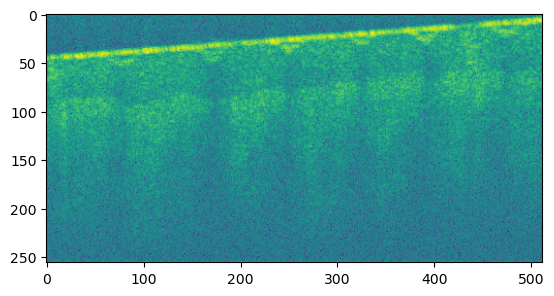

In [ ]:
plt.imshow(data[:,:, 10])

In [ ]:
print(masks.dtype)

int32


In [ ]:
cross_val = 0

ind = 0

train, train_target, test, test_target = made_train_array(cross_val)

<class 'numpy.float64'>
859


In [ ]:
test = test.type(torch.float32)

In [ ]:
test.dtype

torch.float32

In [ ]:
train_target.dtype

torch.float32

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 32, 64, 128, 256, 512]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(32, classes, kernel_size=1)


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []

        for down in self.double_conv_downs:
            x = x.float()
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

In [ ]:
def run_epoch(model, size, train, target, optimizer, criterion, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for i in range(size):
        if is_training:
            optimizer.zero_grad()


        x = train[i].unsqueeze(0).unsqueeze(0).to('cuda')
        y = target[i].unsqueeze(0).to('cuda')

        out = model(x)

        loss = criterion(out, y)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item())


    return epoch_loss/size

Check before running cross-validation:

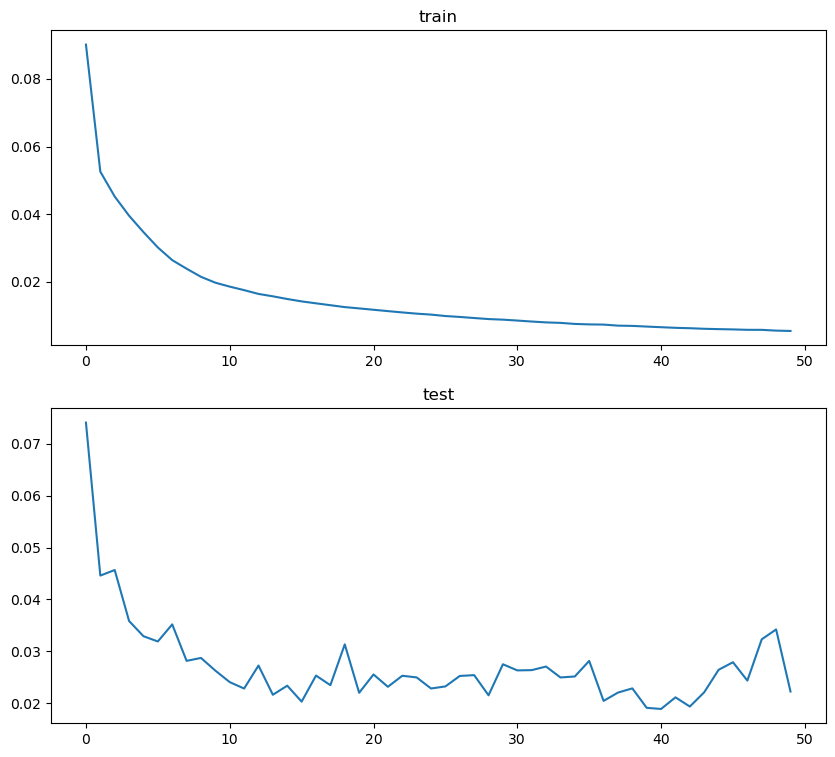

Epoch[50/50] | loss train:0.005513, test:0.022258


In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = UNET(1, 5).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
lr = 0.001

losses_train = []
losses_test = []

best_loss = 1000
for epoch in range(50):
    loss_train = run_epoch(model, 1024, train, train_target, optimizer,  criterion, is_training=True)
    loss_val = run_epoch(model, 256, test, test_target, optimizer,  criterion)
    losses_train.append(loss_train)
    losses_test.append(loss_val)

    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]

        torch.save(model.state_dict(),"C:/Users/MK/Nika/2D/exp1/hyperparameter0/unet2d")

    clear_output(True)
    fig = plt.figure(figsize=(10, 9))

    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 50, loss_train, loss_val))

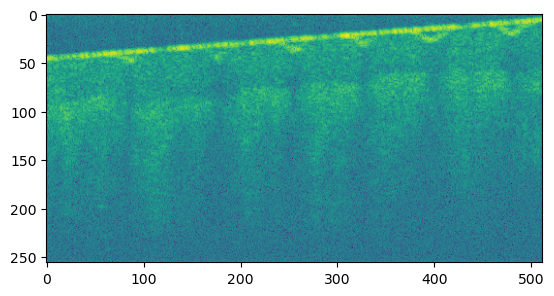

In [ ]:
plt.imshow(test[0])

In [ ]:
np.argmin(losses_test)

40

In [ ]:
np.min(losses_test)

0.01889274444329203

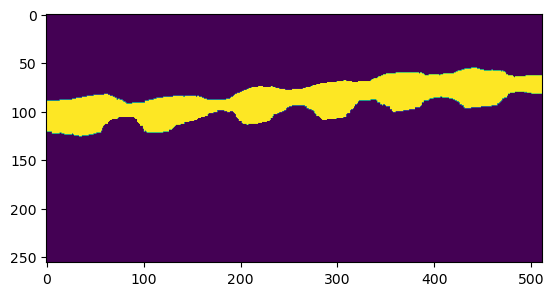

In [ ]:
plt.imshow(test_target[0, 3])

In [ ]:
np.shape(train_target)

torch.Size([1024, 5, 256, 512])

Сross-validation:

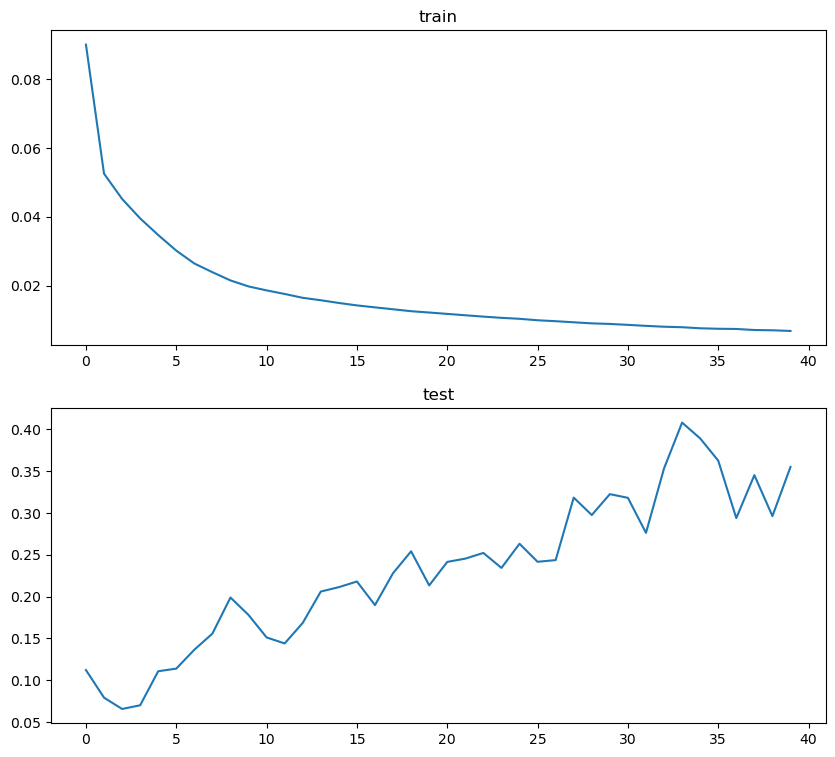

Epoch[40/80] | loss train:0.006813, test:0.355225
CPU times: total: 4h 25min 9s
Wall time: 3h 2min 21s


In [ ]:
%%time
start_end_array = [[41, 41+256], [78, 78+256], [84, 84+256], [161, 161+256], [0, 0+256]]

for cross_val in range(0,5):
    print('cross_val=', cross_val)
    train, train_target, test, test_target = made_train_array(cross_val)

    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True

    model = UNET(1, 5).to('cuda')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
    lr = 0.001

    losses_train = []
    losses_test = []
    # begin training
    best_loss = 1000
    for epoch in range(40):
        loss_train = run_epoch(model, 1024, train, train_target, optimizer,  criterion, is_training=True)
        loss_val = run_epoch(model, 256, test, test_target, optimizer,  criterion)
        losses_train.append(loss_train)
        losses_test.append(loss_val)

        # if losses_test[-1] < best_loss and losses_test[-1] > 0:
        if losses_test[-1] < best_loss:
            best_loss = losses_test[-1]
            # torch.save(model.state_dict(), "/content/drive/MyDrive/diplom/finger1/unet2dBest_air2")
            torch.save(model.state_dict(),"C:/Users/MK/Nika/2D/exp1/hyperparameter0/unet2d" + str(cross_val))

        clear_output(True)
        fig = plt.figure(figsize=(10, 9))

        ax_1 = fig.add_subplot(2, 1, 1)
        ax_2 = fig.add_subplot(2, 1, 2)
        ax_1.set_title('train')
        ax_1.plot(losses_train)
        ax_2.set_title('test')
        ax_2.plot(losses_test)
        plt.show()



        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
                  .format(epoch+1, 80, loss_train, loss_val))

    fig.savefig('C:/Users/MK/Nika/2D/exp1/hyperparameter0/cross_val'+  str(cross_val) + '.png')
    np.save('C:/Users/MK/Nika/2D/exp1/hyperparameter0/losses_train'+  str(cross_val) + '.npy',  losses_train)
    np.save('C:/Users/MK/Nika/2D/exp1/hyperparameter0/losses_test'+  str(cross_val) + '.npy',  losses_test)